# Project 2 Ames Housing
## Pipeline linear modeling

This approach closely follows that presented in class by Mark Popovich and references notes by Douglas Strodtman (SaMo).  


## Import libraries

In [58]:
# Imports:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, RFE

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

from scipy import stats
import statsmodels.api as sm

from itertools import combinations

%matplotlib inline

# Set the graph style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [3]:
# Set relative data path
data_path = "../datasets"
test_dataframe_name = "test_clean.csv"
train_dataframe_name = "train_clean.csv"
y_trn_dataframe_name = "y_clean.csv"

X1_trn = pd.read_csv(os.path.join(data_path, train_dataframe_name))
X1_tst = pd.read_csv(os.path.join(data_path, test_dataframe_name))
y_trn = pd.read_csv(os.path.join(data_path, y_trn_dataframe_name))

print(X1_trn.shape, X1_tst.shape, y_trn.shape)

(2051, 132) (879, 132) (2051, 1)


In [4]:
# Establish lists of variable types
cat_features = ['ms_subclass', 'ms_zoning', 'util', 'lot_config',
                'neigh', 'bld_type', 'hs_style', 
                'ext_qual', 'ext_cond', 'bsmt_cond', 'heat_qc', 'cen_air',
                'kit_qual', 'funct','garag_type', 'pool_qc', 'misc_feat','sale_type']

num_features = ['lot_area', 'over_qual', 'over_cond', 'age_home_at_sale',
                'age_remodel_at_sale', 'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold']


### Split the training data into training and testing subsets

In [5]:
# Split the training data
X1_trn_trn, X1_trn_tst, y_trn_trn, y_trn_tst = train_test_split(X1_trn, y_trn, random_state=223)


## Define functions


In [22]:
def eval_model(y_act, y_pred):
    
    # Make a copy of the y_act dataframe
    df = y_act.copy()
#     df['pred'] = [x[0] for x in y_pred]
    df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    
    # create residuals
    df['res'] = df['act'] - df['pred']
    
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,12))

    # Plot the scatter of the predicted versus actual
    ax[0][0] = sns.scatterplot('act','pred', data=df, ax = ax[0][0])
    ax[0][0] = sns.lineplot('act','act', data=df, ax = ax[0][0], color = 'r')
    ax[0][0].set_title('Predicted versus actuals', fontsize = 14)
    ax[0][0].set_xlabel('Actuals', fontsize = 12)
    ax[0][0].set_ylabel('Predicted', fontsize = 12)
    ax[0][0].text(ax[0][0].get_xlim()[0] + (ax[0][0].get_xlim()[1] - ax[0][0].get_xlim()[0])/10, 
                  ax[0][0].get_ylim()[1] - (ax[0][0].get_ylim()[1] - ax[0][0].get_ylim()[0])/10, 
                  f"R2 {r2:.4}", horizontalalignment='left', 
                  size='medium', color='black', weight='semibold')

    ax[0][0].grid(False)
    
    # Plot the scatter of the residuals versus actuals
    ax[0][1] = sns.scatterplot(x = 'act',y = 'res', data=df, ax = ax[0][1])
    ax[0][1].set_title('Residuals versus actuals', fontsize = 14)
    ax[0][1].set_xlabel('Actuals', fontsize = 12)
    ax[0][1].set_ylabel('Residuals', fontsize = 12)
    ax[0][1].grid(False)
    
    # Plot the residuals
    ax[1][0] = sns.scatterplot(x = df.index,y = 'res', data=df, ax = ax[1][0])
    ax[1][0].set_title('Residuals versus an index', fontsize = 14)
    ax[1][0].set_xlabel('Index', fontsize = 12)
    ax[1][0].set_ylabel('Residuals', fontsize = 12)
    ax[1][0].grid(False)
    
    # Plot the histogram of residuals
    ax[1][1] = sns.distplot( df['res'], ax = ax[1][1])
    ax[1][1].set_title('Histogram of residuals', fontsize = 14)
    ax[1][1].set_xlabel('Residuals', fontsize = 12)
    ax[1][1].set_ylabel('Distribution', fontsize = 12)
    ax[1][1].text(ax[1][1].get_xlim()[0] + (ax[1][1].get_xlim()[1] - ax[1][1].get_xlim()[0])/10, 
                  ax[1][1].get_ylim()[1] - (ax[1][1].get_ylim()[1] - ax[1][1].get_ylim()[0])/10, 
                  f"p value for H0 that normal {r2:.4}", horizontalalignment='left', 
                  size='medium', color='black', weight='semibold')

    ax[1][1].grid(False)
    
# https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
# https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/

## Work with a pipeline

### Create a pipe

In [62]:
# # Create a pipe
# pipe = Pipeline([
#     ('var_thresh', VarianceThreshold(0.05)),
#     ('ss', StandardScaler()),
#     ('kbest',SelectKBest(f_regression, k = 5)),
#     ('lasso', Lasso())  
# ])

# Create a pip
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('kbest',SelectKBest(f_regression, k = 10)),
    ('rfe', RFE(Lasso(),n_features_to_select=None))
])


In [63]:
pipe.fit(X1_trn_trn, y_trn_trn)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a18286400>)), ('rfe', RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0))])

In [64]:
pipe.score(X1_trn_trn, y_trn_trn)

0.800012865231801

### Establish a grid

In [93]:
# Establish the grid parameters to search
params = {
    'kbest__k': [10, 20, 30, 40, 50],
    'rfe__n_features_to_select': [5, 7, 9, 11]
}


In [94]:
# Instantiate the grid search object
gs_model = GridSearchCV(pipe, params)


### Fit and score the model

In [95]:
# fit the model
gs_model.fit(X1_trn_trn, y_trn_trn)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a18286400>)), ('rfe', RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [10, 20, 30, 40, 50], 'rfe__n_features_to_select': [5, 7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [96]:
# Generate predictions from the 
pred_gs_trn_tst = gs_model.predict(X1_trn_tst)


In [97]:
# score the training data
print(grid_search.score(X1_trn_trn, y_trn_trn))
print(grid_search.score(X1_trn_tst, y_trn_tst))

0.8296573326588426
0.7040838284192837


## Evaluate the model

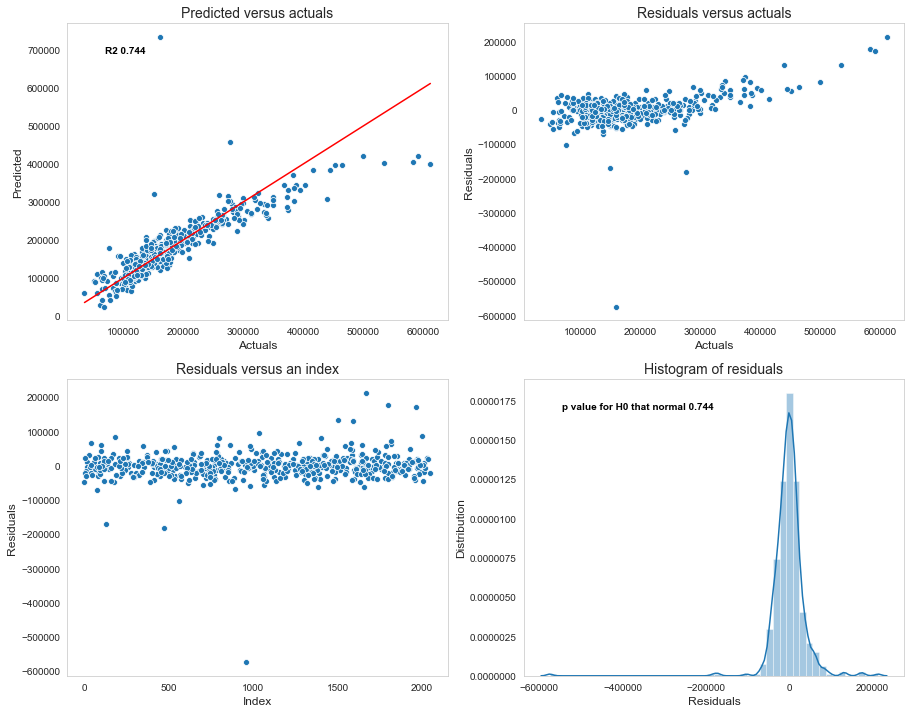

In [98]:
eval_model(y_trn_tst, pred_gs_trn_tst)

## Examine the model

In [99]:
# Get the kbest parameters
print(gs_model.best_estimator_.named_steps['kbest'])

print(gs_model.best_estimator_.named_steps['rfe'])


SelectKBest(k=20, score_func=<function f_regression at 0x1a18286400>)
RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=11, step=1, verbose=0)


## Examine the coefficients

In [100]:
# Look at the variables after the transformations
columns = X1_trn.columns
columns = columns[gs_model.best_estimator_.named_steps['kbest'].get_support()]
columns = columns[gs_model.best_estimator_.named_steps['rfe'].get_support()]
print(columns)

Index(['lot_area', 'over_qual', 'tot_bsmt_sf', 'gr_liv_area', 'neigh_NridgHt',
       'ext_qual_Gd', 'ext_qual_TA', 'kit_qual_Gd', 'kit_qual_TA',
       'age_home_at_sale', 'age_remodel_at_sale'],
      dtype='object')


In [101]:
# get the intercept
# intercept = gs_model.best_estimator_.named_steps['rfe'].intercept_

# get the coefficients

intercept = gs_model.best_estimator_.named_steps['rfe'].estimator_.intercept_
coefficients = gs_model.best_estimator_.named_steps['rfe'].estimator_.coef_
print(coefficients)

[  9322.40033543  25145.66451491  11845.3494593   23822.56345188
   4990.85556784 -10514.05699539 -12959.24404082 -13047.34035818
 -13475.84842944 -10372.00682826  -5694.85952887]


## create a dataframe of the coeffients


In [102]:
model = pd.DataFrame(coefficients, index = columns, columns=['coeff'])
model

,coeff
lot_area,9322.400335
over_qual,25145.664515
tot_bsmt_sf,11845.349459
gr_liv_area,23822.563452
neigh_NridgHt,4990.855568
ext_qual_Gd,-10514.056995
ext_qual_TA,-12959.244041
kit_qual_Gd,-13047.340358
kit_qual_TA,-13475.848429
age_home_at_sale,-10372.006828


NameError: name 'y_test' is not defined

Reference

https://machinelearningmastery.com/feature-selection-machine-learning-python/
https://stackoverflow.com/questions/34204898/how-to-get-the-coefficients-from-rfe-using-sklearn
